# Medida de la masa invariante

Con este ejercicio se pretende medir la masa invariante de las diferentes resonancias que se encuentran en el espectro de dimuones:  J/psi, Upsilon y Z.  Se propone graficar la distribución y ajustarla para extraer el valor de la masa (valor medio) y su resolución (ancho). 

Habrá que probar diferentes funciones de ajuste y comparar el resultado obtenido:
- gausiana
- cristal-ball
- gausiana+2exp (cruijff)

__¿Cuál es la mejor función para cada resonancia?__

### 1) Obteniendo el archivo y las masas

Empecemos con el código donde los módulos necesarios de Python son importados y el archivo de datos es obtenido. Explore los comentarios en el código y ejecute el código dando clic sobre la casilla y presionando _Ctrl_ + _Enter_. Después de eso puede avanzar a la parte dos. Puede que obtenga una advertencia relacionada al módulo _matplotlib_ pero no es necesario preocuparse por eso. 

In [1]:
# Importar todos los módulos necesarios. Pandas es para análisis de datos, numpy es para cálculos científicos
# y matplotlib.pyplot es para hacer gráficas. Los módulos son llamados pd, np y plt.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear una nueva estructura de marco de datos desde el archivo "Zmumu_Run2011A_masses.csv"
dataset_Z    = pd.read_csv('../Datos/Zmumu_Run2011A.csv')
dataset_Jpsi = pd.read_csv('../Datos/Jpsimumu_Run2011A.csv')
dataset_Y    = pd.read_csv('../Datos/Ymumu_Run2011A.csv')

# Crear una estructura de serie (básicamente una lista) y nombrarla "masa_invariante".
# Guardar la columna "M" desde "dataset" hacia la variable "masa_invariante".
Z_mm = np.sqrt(2*dataset_Z.pt1*dataset_Z.pt2*(np.cosh(dataset_Z.eta1-dataset_Z.eta2) - np.cos(dataset_Z.phi1-dataset_Z.phi2)))
Jpsi_mm = np.sqrt(2*dataset_Jpsi.pt1*dataset_Jpsi.pt2*(np.cosh(dataset_Jpsi.eta1-dataset_Jpsi.eta2) - np.cos(dataset_Jpsi.phi1-dataset_Jpsi.phi2)))
Y_mm = np.sqrt(2*dataset_Y.pt1*dataset_Y.pt2*(np.cosh(dataset_Y.eta1-dataset_Y.eta2) - np.cos(dataset_Y.phi1-dataset_Y.phi2)))


### 2) Definir funciones de ajuste

In [2]:
from scipy.optimize import curve_fit

def expo(x, *params):
    """ An exponential curve. *NB* The constant is in the exponent! 
    params: const, slope """
    const, slope = params
    return np.exp(const + slope*x)

def double_exp(x, *params):
    """ Two exponential constants in one.
    params: const1, slope1, mu1, const2, slope2, mu2 """
    exp1 = params[0]*np.exp(params[1]*x + params[2])
    exp2 = params[3]*np.exp(params[4]*x + params[5])
    return exp1*exp2

def pol1(x, *params):
    """ Just another name for pol1. """
    intercept, slope = params
    return slope*x + intercept

def pol2(x, *params):
    p0, p1, p2 = params
    return p0 + p1*x + p2*x**2


def gaus(x, *params):
    # An un-normalized Gaussian curve.
    # params: N, mu, sigma """abs
    N, mu, sigma = params
    return N*np.exp(-0.5 * ((x-mu)/sigma)**2 )

def gaus_pol2(x, *params):
    # An un-normalized Gaussian curve.
    # params: N, mu, sigma """abs
    N, mu, sigma, p0, p1, p2 = params
    return N*(np.exp(-0.5 * ((x-mu)/sigma)**2 ) + p0 + p1*x + p2*x**2 )

def gaus_exp(x, *params):
    # An un-normalized Gaussian curve.
    # params: N, mu, sigma """abs
    N, mu, sigma, const, slope = params
    return N*(np.exp(-0.5 * ((x-mu)/sigma)**2 ) +  np.exp(const + slope*x) )

## para el Upsilon
def triple_gaus( x, *params):
 #   c1, mu1, sigma1, c2, mu2, sigma2, c3, mu3, sigma3 = params
 #   res =    np.divide(1,x)*c1 * np.exp( - (np.log(x) - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
 #         +  np.divide(1,x)*c2 * np.exp( - (np.log(x) - mu2)**2.0 / (2.0 * sigma2**2.0) ) \
 #         +  np.divide(1,x)*c3 * np.exp( - (np.log(x) - mu3)**2.0 / (2.0 * sigma3**2.0) )
    c1, mu1, sigma1, c2, mu2, sigma2, c3, mu3, sigma3 = params
    gaus1=c1*np.exp(-0.5 * ((x-mu1)/sigma1)**2 )
    gaus2=c1*np.exp(-0.5 * ((x-mu2)/sigma2)**2 )
    gaus3=c1*np.exp(-0.5 * ((x-mu3)/sigma3)**2 )
    return gaus1+gaus2+gaus3

def triple_gaus_pol2( x, *params):
    c1, mu1, sigma1, c2, mu2, sigma2, c3, mu3, sigma3, p0, p1, p2 = params
#    res =    np.divide(1,x)*c1 * np.exp( - (np.log(x) - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
#          +  np.divide(1,x)*c2 * np.exp( - (np.log(x) - mu2)**2.0 / (2.0 * sigma2**2.0) ) \
#          +  np.divide(1,x)*c3 * np.exp( - (np.log(x) - mu3)**2.0 / (2.0 * sigma3**2.0) )
    gaus1=c1*np.exp(-0.5 * ((x-mu1)/sigma1)**2 )
    gaus2=c1*np.exp(-0.5 * ((x-mu2)/sigma2)**2 )
    gaus3=c1*np.exp(-0.5 * ((x-mu3)/sigma3)**2 )
    res = gaus1+gaus2+gaus3 + p0 + p1*x + p2*x**2
    return res

def crystal_ball(x, *params):
    """ A Gaussian curve on one side and a power-law on the other side. Used in
    physics to model lossy processes.
    See http://en.wikipedia.org/wiki/Crystal_Ball_function
  Note that the definition used here differs slightly. At the time of this
  writing, the wiki article has some discrepancies in definitions/plots. This
  definition makes it easier to fit the function by using complex numbers
  and by negating any negative values for a and n.
  This version of the crystal ball is normalized by an additional parameter.
  params: N, a, n, xb, sig
  """
    x = x+0j # Prevent warnings...
    N, a, n, xb, sig = params
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n/aa)**n * np.exp(- aa**2 / 2)
    B = n/aa - aa
    total = 0.*x
    total += ((x-xb)/sig  > -a) * N * np.exp(- (x-xb)**2/(2.*sig**2))
    total += ((x-xb)/sig <= -a) * N * A * (B - (x-xb)/sig)**(-n)
    try:
        return total.real
    except:
        return total
    return total


def crystal_ball_exp(x, *params):
    """ A Gaussian curve on one side and a power-law on the other side. Used in
    physics to model lossy processes.
    See http://en.wikipedia.org/wiki/Crystal_Ball_function
  Note that the definition used here differs slightly. At the time of this
  writing, the wiki article has some discrepancies in definitions/plots. This
  definition makes it easier to fit the function by using complex numbers
  and by negating any negative values for a and n.
  This version of the crystal ball is normalized by an additional parameter.
  params: N, a, n, xb, sig
  """
    x = x+0j # Prevent warnings...
    N, a, n, xb, sig, const, slope = params
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n/aa)**n * np.exp(- aa**2 / 2)
    B = n/aa - aa
    total = 0.*x
    total += ((x-xb)/sig  > -a) * N * np.exp(- (x-xb)**2/(2.*sig**2))
    total += ((x-xb)/sig <= -a) * N * A * (B - (x-xb)/sig)**(-n)
    total += N*np.exp(const + slope*x) 
    try:
        return total.real
    except:
        return total
    return total

    
def cruijff(x, *params):
    n, mu, sig, alphaL, alphaR = params
    x = x+0j # Prevent warnings...
    dx = x-mu
    
    f =  2*sig*sig
    f += (dx<0)*alphaL*dx*dx
    f += (dx>0)*alphaR*dx*dx
    sol = n * (np.exp(-dx*dx/f))
    try: 
        return sol.real
    except:
        return sol
    return sol 


def centers_from_borders(borders):
    return borders[:-1] + np.diff(borders) / 2

### 3) Pintar las distribuciones

####  $J/\psi$

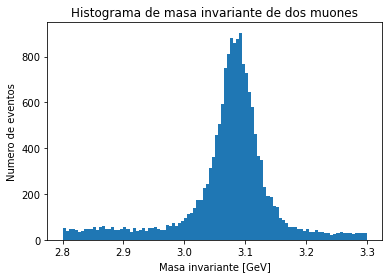

In [3]:
# pintamos el J/psi:

%matplotlib inline
n_jpsi, bins_jpsi, _ = plt.hist(Jpsi_mm, bins=100, range=[2.8,3.3])
x_jpsi = centers_from_borders(bins_jpsi)

plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Numero de eventos')
plt.title('Histograma de masa invariante de dos muones')
plt.show()

[ 8.47965661e+02  3.08531153e+00 -3.15945696e-02]


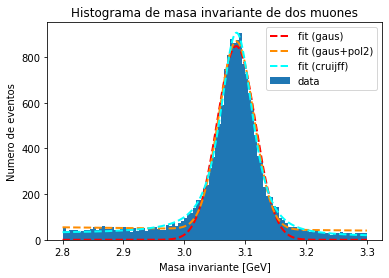

The mass of the J/psi is 3.09 +/- 0.03 GeV (Gauss)
The mass of the J/psi is 3.09 +/- 0.03 GeV (Gauss+exp)
The mass of the J/psi is 3.09 +/- 0.02 GeV (Cruijff)


In [4]:
par_g, par_cov_g = curve_fit(gaus, x_jpsi, n_jpsi, p0 = [1, 3.1, 0.5])
print(par_g)
par_ge, par_cov_ge = curve_fit(gaus_exp, x_jpsi, n_jpsi, p0 = [par_g[0], par_g[1], par_g[2], 1.,0.], method='trf') #, bounds=((-np.inf,2.8,-2,-np.inf,-np.inf,-np.inf),(np.inf,3.3,2.,np.inf,np.inf,np.inf)))

#par_cb, par_cov_cb = curve_fit(crystal_ball, x_jpsi, n_jpsi, p0 = [1, 3.1, 0.5])
par_cr, par_cov_cr = curve_fit(cruijff, x_jpsi, n_jpsi, p0 = [par_g[0], par_g[1], par_g[2],1.0,1.0], 
                               bounds=((0,0.5*par_g[1],-2,0,0),(2*par_g[0],1.5*par_g[1],2,2,2)),
                               method='trf')

# Plot the histogram and the fitted function.
xspace=np.linspace(2.8,3.3,1000)
plt.hist(Jpsi_mm, bins=100, range=[2.8,3.3], label='data')
plt.plot(xspace, gaus(xspace,*par_g ), 'r--', linewidth=2, label='fit (gaus)')
plt.plot(xspace, gaus_exp(xspace,*par_ge), '--', color='darkorange', linewidth=2, label='fit (gaus+pol2)')
plt.plot(xspace, cruijff(xspace,*par_cr), '--', color='cyan', linewidth=2, label='fit (cruijff)')

# Make the plot nicer.
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Numero de eventos')
plt.title('Histograma de masa invariante de dos muones')
plt.legend(loc='best')
plt.show()

print("The mass of the J/psi is {:3.2f} +/- {:3.2f} GeV (Gauss)".format(par_g[1],abs(par_g[2])))
print("The mass of the J/psi is {:3.2f} +/- {:3.2f} GeV (Gauss+exp)".format(par_ge[1],abs(par_ge[2])))
print("The mass of the J/psi is {:3.2f} +/- {:3.2f} GeV (Cruijff)".format(par_cr[1],abs(par_cr[2])))

#### $\Upsilon$

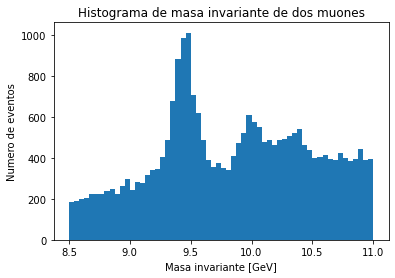

In [5]:
# pintamos el J/psi:
%matplotlib inline
n_upsilon, bins_upsilon, _= plt.hist(Y_mm, bins=60, range=[8.5,11])
x_upsilon = centers_from_borders(bins_upsilon)
    
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Numero de eventos')
plt.title('Histograma de masa invariante de dos muones')
plt.show()

[ 9.75247587e+02  9.44246187e+00 -1.15692089e-01] [5.72610759e+02 1.00249723e+01 2.13807496e-01] [ 5.23233362e+02  1.03352109e+01 -2.45089561e-01]


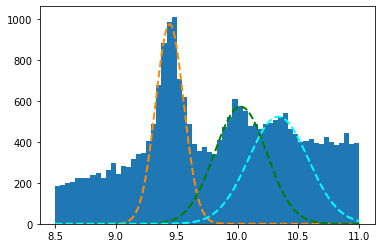

In [6]:
## prepare data:
def trim_data(x_data,n_data,minval,maxval):
    xout = []
    nout = []
    for i in range(len(x_data)): 
        if (x_data[i]>minval and x_data[i]<maxval):
            xout.append(x_data[i])
            nout.append(n_data[i])
    return xout,nout
                    
x_upsilon_0, n_upsilon_0 = trim_data(x_upsilon,n_upsilon,9.25,9.55)
x_upsilon_1, n_upsilon_1 = trim_data(x_upsilon,n_upsilon,9.8,10.2)
x_upsilon_2, n_upsilon_2 = trim_data(x_upsilon,n_upsilon,10.2,10.5)

##  plot each gaus
par_g0,_ =  curve_fit(gaus,x_upsilon_0,n_upsilon_0, p0=[1.,9.1,1.])
par_g1,_ =  curve_fit(gaus,x_upsilon_1,n_upsilon_1, p0=[par_g0[0],10.,1.])
par_g2,_ =  curve_fit(gaus,x_upsilon_2,n_upsilon_2, p0=[par_g0[0],10.2,1.])

xspace=np.linspace(8.5,11,1000)
plt.hist(Y_mm, bins=60, range=[8.5,11])
plt.plot(xspace, gaus(xspace,*par_g0 ), '--', color='darkorange', linewidth=2, label='fit (gaus)')
plt.plot(xspace, gaus(xspace,*par_g1 ), '--', color='green', linewidth=2, label='fit (gaus)')
plt.plot(xspace, gaus(xspace,*par_g2 ), '--', color='cyan', linewidth=2, label='fit (gaus)')

print(par_g0,par_g1,par_g2)

[ 4.83495550e+02  9.44262335e+00 -8.63974246e-02  1.92394496e+06
  9.99886565e+00  1.24185394e-02 -5.71301981e+05  1.02318588e+01
 -1.18362064e+00]


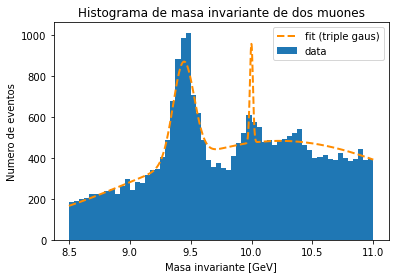

The masses of the Upsilon  resonances are:9.4426 +/- 0.0864 GeV 
                                          9.9989 +/- 0.0124 GeV 
                                          10.2319 +/- 1.1836 GeV 


In [7]:
par_tg0, par_cov_tg0 = curve_fit(triple_gaus, x_upsilon, n_upsilon, p0=[par_g0[0], par_g0[1], par_g0[2], par_g1[0], par_g1[1], par_g1[2], par_g2[0], par_g2[1], par_g2[2]], 
                                 bounds=((-np.inf,0.99*par_g0[1],-np.inf,-np.inf,0.99*par_g1[1],-np.inf,-np.inf,0.99*par_g2[1],-np.inf), 
                                        (np.inf,1.01*par_g0[1],np.inf,np.inf,1.01*par_g1[1],np.inf,np.inf,1.01*par_g2[1],np.inf)), method='trf')

#par_tg, par_cov_tg = curve_fit(triple_gaus_pol2, x_upsilon, n_upsilon, p0=[par_tg0[0], par_tg0[1], par_tg0[2], par_tg0[0], par_tg0[1], par_tg0[2], par_tg0[0], par_tg0[1], par_tg0[2], 1.,1.,1.], 
#                               method='trf')
#par_cb, par_cov_cb = curve_fit(crystal_ball, x_jpsi, n_jpsi, p0 = [1, 3.1, 0.5])
#par_cr, par_cov_cr = curve_fit(cruijff, x_jpsi, n_jpsi, p0 = [par_g[0], par_g[1], par_g[2],1.0,1.0])
print (par_tg0)

# Plot the histogram and the fitted function.
xspace=np.linspace(8.5,11,1000)
plt.hist(Y_mm, bins=60, range=[8.5,11], label='data')
#plt.plot(xspace, triple_gaus_pol2(xspace,*par_tg ), '--', color='red', linewidth=2, label='fit (triple gaus + pol2)')
plt.plot(xspace, triple_gaus(xspace,*par_tg0 ), '--', color='darkorange', linewidth=2, label='fit (triple gaus)')

# Make the plot nicer.
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Numero de eventos')
plt.title('Histograma de masa invariante de dos muones')
plt.legend(loc='best')
plt.show()

print("The masses of the Upsilon  resonances are:{:3.4f} +/- {:3.4f} GeV ".format(par_tg0[1],abs(par_tg0[2]))) 
print("                                          {:3.4f} +/- {:3.4f} GeV ".format(par_tg0[4],abs(par_tg0[5])))
print("                                          {:3.4f} +/- {:3.4f} GeV ".format(par_tg0[7],abs(par_tg0[8])))


#### $ Z^0 $

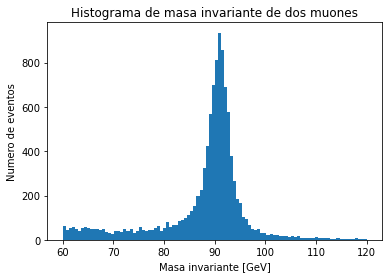

In [8]:
%matplotlib inline
n_z, bins_z, _ = plt.hist(Z_mm, bins=100, range=[60,120])
x_z = centers_from_borders(bins_z)

plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Numero de eventos')
plt.title('Histograma de masa invariante de dos muones')
plt.show()

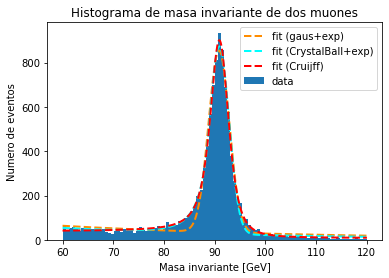

The mass of the Z is 90.8 +/- 2.2 GeV (Gauss)
                     90.8 +/- 2.0 GeV (Gauss+exp)
                     90.9 +/- 2.1 GeV (CrystalBall)
                     90.9 +/- 1.9 GeV (CB+exp)
                     90.9 +/- 1.7 GeV (Cruijff)


In [9]:
par_g, par_cov_g = curve_fit(gaus, x_z, n_z, p0 = [1, 90, 1.]) 
par_ge, par_cov_ge = curve_fit(gaus_exp, x_z, n_z, p0 = [par_g[0], par_g[1], par_g[2], 1.,0.], method='trf')
par_cb, par_cov_cb = curve_fit(crystal_ball, x_z, n_z, p0 = [par_g[0], 1., 1., 90, par_g[2]], 
                               bounds=((0.5*par_g[0],-5,-5,85,-3),(1.5*par_g[0],5,5,95,3)),
                               method='trf')
par_cbe, par_cov_cbe = curve_fit(crystal_ball_exp, x_z, n_z, p0 = [par_g[0], 1., 1., 90, par_g[2],par_ge[3],par_ge[4]], 
                                bounds=((0.5*par_g[0],-5,-5,85,-3,-np.inf,-np.inf),(1.5*par_g[0],5,5,95,3,np.inf,np.inf)),
                               method='trf')
par_cr, par_cov_cr = curve_fit(cruijff, x_z, n_z, p0 = [par_g[0], par_g[1], par_g[2],0.19,0.01], 
                               bounds=((0,par_g[1]-0.5*par_g[2],0,0,0),(1.1*par_g[0],par_g[1]+0.5*par_g[2],1.2*par_g[2],2,2)),
                               method='trf')

# Plot the histogram and the fitted function.
xspace=np.linspace(60,120,1000)
plt.hist(Z_mm, bins=100, range=[60,120], label='data')
plt.plot(xspace, gaus_exp(xspace,*par_ge ), '--', color='darkorange', linewidth=2, label='fit (gaus+exp)')
#plt.plot(xspace, crystal_ball(xspace,*par_cb ), '--', color='yellow', linewidth=2, label='fit (CrystalBall)')
plt.plot(xspace, crystal_ball_exp(xspace,*par_cbe ), '--', color='cyan', linewidth=2, label='fit (CrystalBall+exp)')
plt.plot(xspace, cruijff(xspace,*par_cr ), '--', color='red', linewidth=2, label='fit (Cruijff)')

# Make the plot nicer.
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Numero de eventos')
plt.title('Histograma de masa invariante de dos muones')
plt.legend(loc='best')
plt.show()

print("The mass of the Z is {:3.1f} +/- {:3.1f} GeV (Gauss)".format(par_g[1],abs(par_g[2])))
print("                     {:3.1f} +/- {:3.1f} GeV (Gauss+exp)".format(par_ge[1],abs(par_ge[2])))
print("                     {:3.1f} +/- {:3.1f} GeV (CrystalBall)".format(par_cb[3],abs(par_cb[4])))
print("                     {:3.1f} +/- {:3.1f} GeV (CB+exp)".format(par_cbe[3],abs(par_cbe[4])))
print("                     {:3.1f} +/- {:3.1f} GeV (Cruijff)".format(par_cr[1],abs(par_cr[2])))


### CALCULAR BEST-FIT: 